#Unsupervised Learning

### Isolation Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import joblib
# Load data from the provided link
url = 'https://drive.google.com/uc?export=download&id=1BvQRvWXdbpXpOaSahEMovATmKQuQilQa'

In [2]:
# Load data
data = pd.read_csv(url)

#'Datetime' column to datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Sorting data by 'Datetime'
data = data.sort_values('Datetime')

#differences and rolling statistics
data['SMA_diff'] = data['SMA'].diff().fillna(0)
data['SMA_roll_mean'] = data['SMA'].rolling(window=5).mean().fillna(method='bfill')
data['SMA_roll_std'] = data['SMA'].rolling(window=5).std().fillna(method='bfill')

#lag features
for lag in range(1, 6):
    data[f'SMA_lag_{lag}'] = data['SMA'].shift(lag).fillna(method='bfill')

#rate of change
data['SMA_rate_of_change'] = data['SMA_diff'] / data['Datetime'].diff().dt.total_seconds().fillna(1)

#time-based feature (e.g., time of day)
data['hour'] = data['Datetime'].dt.hour
data['day_of_week'] = data['Datetime'].dt.dayofweek

#Feature Selection
features = ['SMA', 'SMA_diff', 'SMA_roll_mean', 'SMA_roll_std', 'SMA_rate_of_change', 'hour', 'day_of_week']
features += [f'SMA_lag_{lag}' for lag in range(1, 6)]
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
#Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly_score'] = iso_forest.fit_predict(X_scaled)

In [4]:
# Mark anomalies
data['anomaly'] = data['anomaly_score'] == -1

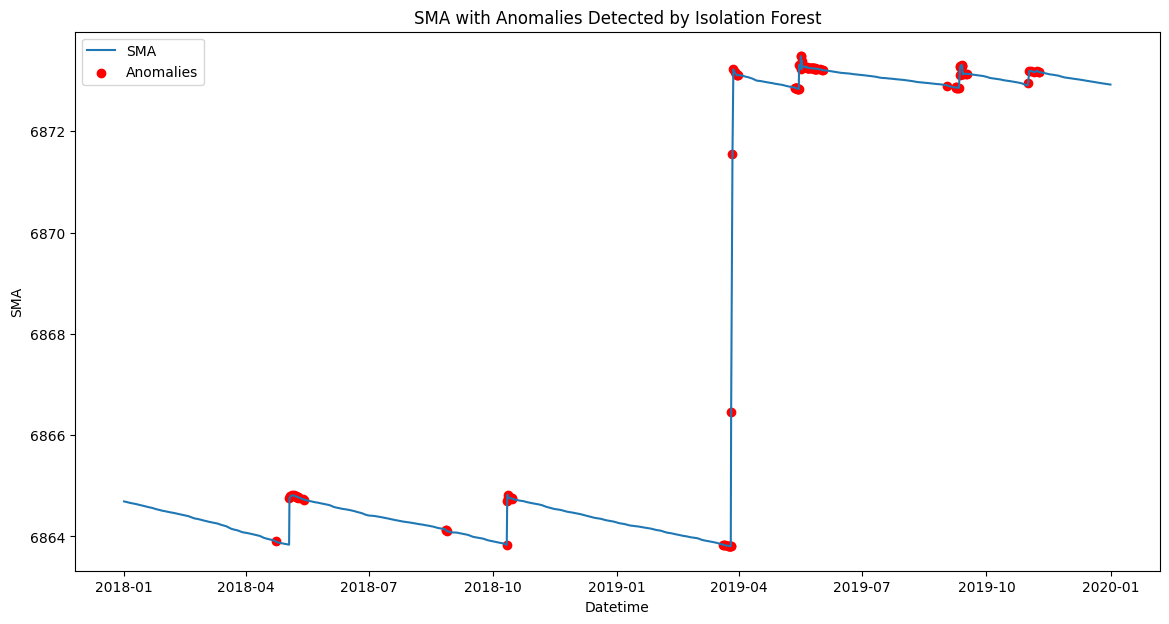

In [5]:
#the data and anomalies
plt.figure(figsize=(14, 7))
plt.plot(data['Datetime'], data['SMA'], label='SMA')
plt.scatter(data['Datetime'][data['anomaly']], data['SMA'][data['anomaly']], color='red', label='Anomalies', marker='o')
plt.xlabel('Datetime')
plt.ylabel('SMA')
plt.title('SMA with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()

In [6]:
# Saveing the DataFrame with anomalies
output_file = 'data_with_anomalies.csv'
data.to_csv(output_file, index=False)

In [7]:
#only rows labeled as anomalies
anomalies = data[data['anomaly'] == True]
print(anomalies)

                       Datetime          SMA  SMA_diff  SMA_roll_mean  \
350  2018-04-23 05:10:29.027136  6863.902334 -0.005095    6863.912039   
384  2018-05-03 12:01:31.056960  6864.749568  0.911916    6864.022284   
385  2018-05-04 03:52:43.845312  6864.792684  0.043115    6864.212295   
386  2018-05-05 05:00:10.439424  6864.810374  0.017690    6864.406126   
387  2018-05-06 12:41:49.412832  6864.808904 -0.001469    6864.599837   
...                         ...          ...       ...            ...   
2121 2019-11-03 04:27:05.197248  6873.192347 -0.001083    6873.031328   
2122 2019-11-05 13:20:15.163584  6873.165250 -0.027097    6873.082970   
2123 2019-11-07 17:18:11.784672  6873.196798  0.031548    6873.141125   
2124 2019-11-08 20:08:28.311648  6873.169069 -0.027729    6873.183379   
2125 2019-11-09 00:55:06.255840  6873.169129  0.000060    6873.178518   

      SMA_roll_std    SMA_lag_1    SMA_lag_2    SMA_lag_3    SMA_lag_4  \
350       0.007611  6863.907429  6863.912105  686

### DBSCAN

In [8]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['dbscan_labels'] = dbscan.fit_predict(X_scaled)

In [9]:
#label outliers with -1
data['dbscan_anomaly'] = data['dbscan_labels'] == -1

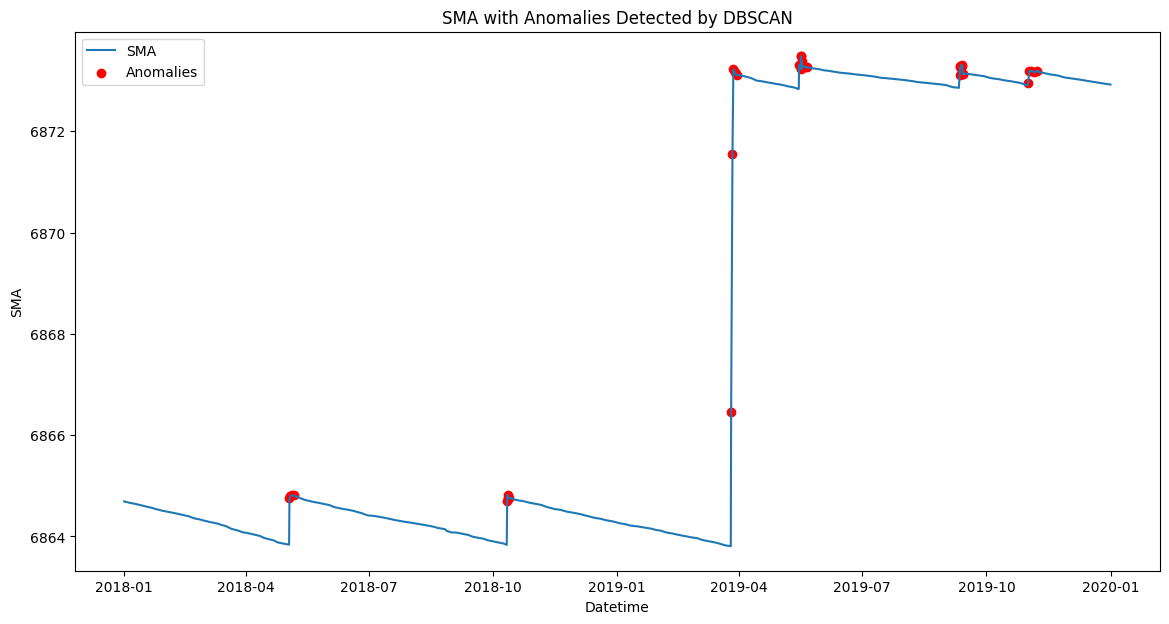

In [10]:
#the data and anomalies detected by DBSCAN
plt.figure(figsize=(14, 7))
plt.plot(data['Datetime'], data['SMA'], label='SMA')
plt.scatter(data['Datetime'][data['dbscan_anomaly']], data['SMA'][data['dbscan_anomaly']], color='red', label='Anomalies', marker='o')
plt.xlabel('Datetime')
plt.ylabel('SMA')
plt.title('SMA with Anomalies Detected by DBSCAN')
plt.legend()
plt.show()

# Supervised Classification Algorithm

### Random Forest

In [11]:
# Load the data
data = pd.read_csv('data_with_anomalies.csv')

# Extract features and target variable
features = ['SMA', 'SMA_diff', 'SMA_roll_mean', 'SMA_roll_std', 'SMA_rate_of_change', 'hour', 'day_of_week']
features += [f'SMA_lag_{lag}' for lag in range(1, 6)]
X = data[features]
y = data['anomaly']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Train a Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Make predictions on the test set
y_pred = classifier.predict(X_test_scaled)
y_pred_prob = classifier.predict_proba(X_test_scaled)[:, 1]

In [14]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[431   1]
 [  8  19]]


In [15]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred)*100)
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_prob))


Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       432
        True       0.95      0.70      0.81        27

    accuracy                           0.98       459
   macro avg       0.97      0.85      0.90       459
weighted avg       0.98      0.98      0.98       459


Accuracy Score:
98.0392156862745

ROC AUC Score:
0.9942986968449931


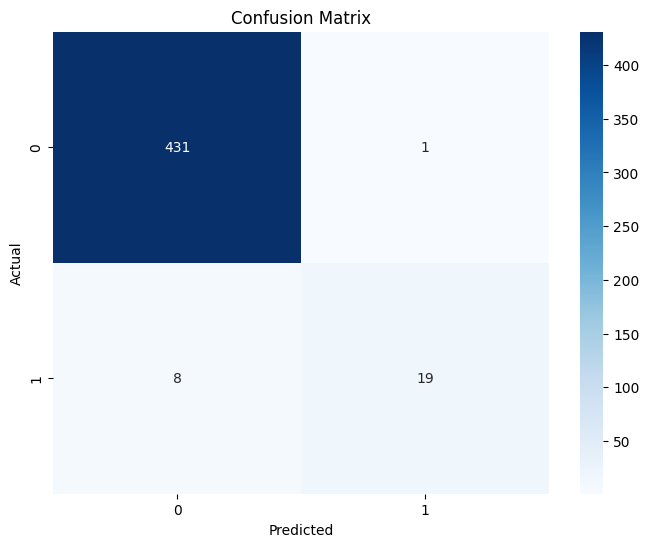

In [16]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

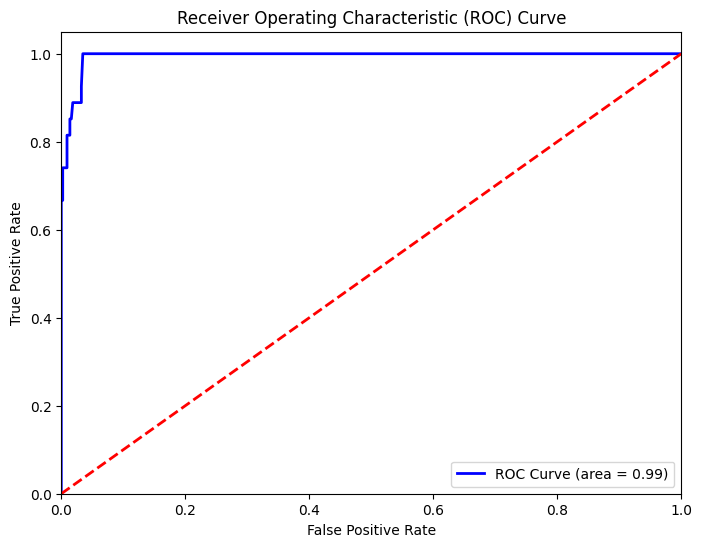

In [17]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Get feature importances
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

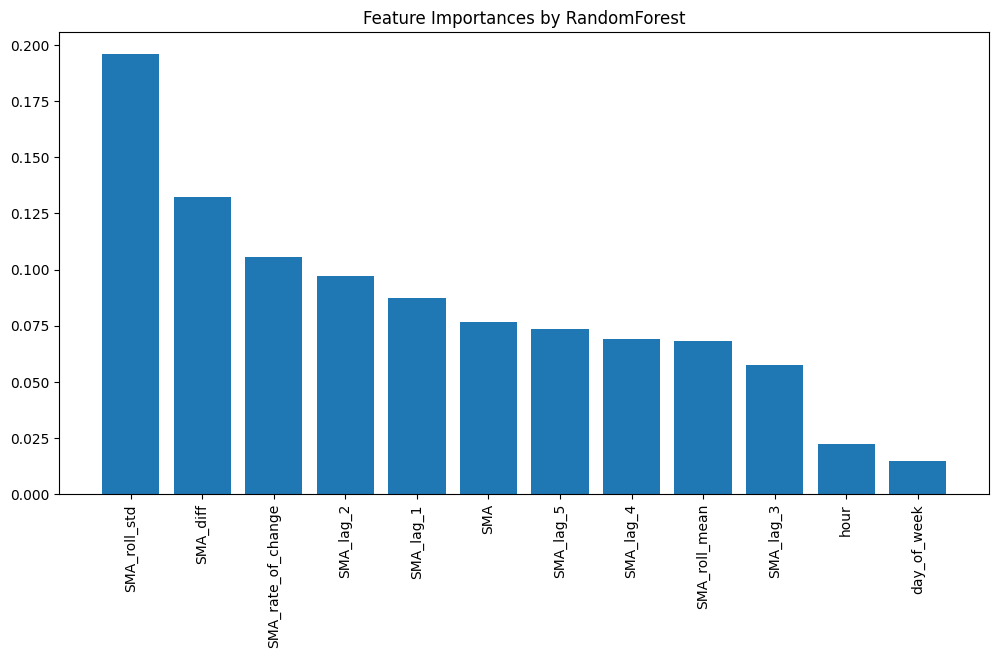

In [19]:
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances by RandomForest")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

In [20]:
# Save the trained model and scaler
joblib.dump(classifier, 'random_forest_classifier.pkl')

['random_forest_classifier.pkl']